# Fitting the H.E.S.S. Crab spectrum with iminuit and emcee

As an example of a chi^2 fit, we use the flux points from the Crab nebula
as measured by H.E.S.S. in 2006:  http://adsabs.harvard.edu/abs/2006A%26A...457..899A

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

## The data

We start by loading the flux points from a text file.

It is of course possible to load this data using just Python
or Numpy, but we'll use the [pandas.read_table](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_table.html) function
because it's very flexible, i.e. by setting a few arguments you'll
be able to load most ascii tables.

**EDIT: Now I will try to replace the pandas data table with Gammapy's FluxPoints class. I will select the source 3FGL J1459.4-6053.**

In [2]:
from gammapy.catalog import SourceCatalog3FGL, SourceCatalogObject3FGL

cat = SourceCatalog3FGL()
source = cat['3FGL J1459.4-6053']
# source = cat['3FGL J0534.5+2201i'] # crab
data = source.flux_points.table


data.info()
# data.show_in_browser()

<Table length=5>
   name     dtype        unit     
---------- ------- ---------------
     e_ref float64             MeV
     e_min float64             MeV
     e_max float64             MeV
      flux float32     1 / (cm2 s)
 flux_errn float32     1 / (cm2 s)
 flux_errp float32     1 / (cm2 s)
     eflux float32   erg / (cm2 s)
eflux_errn float32   erg / (cm2 s)
eflux_errp float32   erg / (cm2 s)
      dnde float64 1 / (cm2 s TeV)


## The model

In the paper they fit a power-law with an exponential cutoff and find the following parameters (see row "all" in table 6):
* gamma = 2.39 +- 0.03
* energy_cut = 14.3 +- 2.1 TeV
* flux1 = (3.76 +- 0.07) x 1e-11 cm^-2 s^-1 TeV^-1

The flux1 is the differential flux at 1 TeV.

Let's code up that model ...


TODO: extend this tutorial to also consider a power-law model and compare the two models via chi2 / ndf.

In [3]:
def flux_ecpl(energy, flux1, gamma, energy_cut):
    return flux1 * energy ** (-gamma) * np.exp(-energy / energy_cut)

## Plot data and model

Let's plot the data and model and compare to Figure 18b
from the paper ...

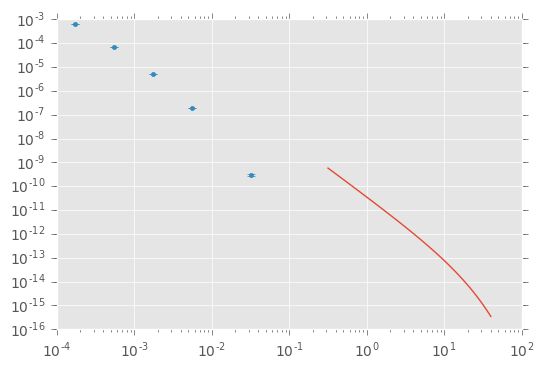

In [4]:
energy = np.logspace(-0.5, 1.6, 100)

# What three values should I use here for the new source? Right now they are
# for the Crab model.
flux = flux_ecpl(energy, flux1=3.76e-11, gamma=2.39, energy_cut=14.3)

plt.plot(energy, flux)

plt.errorbar(x=data['e_ref'] / 1e6, # convert MeV to TeV
             y=data['dnde'],
             yerr=data['flux_errp'], # or is it ['flux_errn']?
             fmt='.'
            )
plt.loglog();

C:\Users\arjun_000\Anaconda3\lib\site-packages\pandas\io\parsers.py:1961: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
C:\Users\arjun_000\Anaconda3\lib\site-packages\pandas\io\parsers.py:1963: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


[]

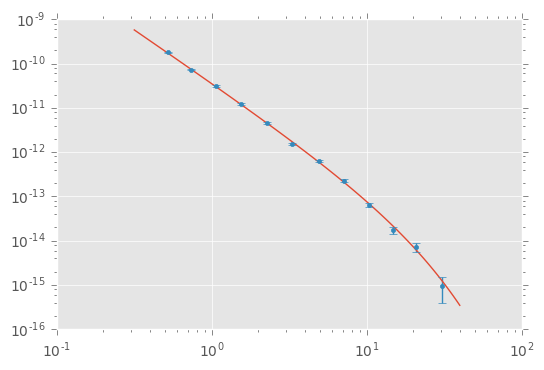

In [5]:
# This is the plot for the Crab model using data from the .txt file.

data2 = pd.read_table('../datasets/spectrum_crab_hess_2006/spectrum_crab_hess_2006.txt',
                    comment='#', sep='\s*', engine='python')
plt.plot(energy, flux)
plt.errorbar(x=data2['energy'],
             y=data2['flux'],
             yerr=data2['flux_err'],
             fmt='.'
            )
plt.loglog()

# The likelihood

In this case we'll use a chi^2 likelihood function to
fit the model to the data.

Note that the likelihood function combines the data and model, and just depends on the model parameters that
shall be estimated (whereas the model function `flux_ecpl` has an extra parameter `energy`).

Also note that we're accessing `data` and model `flux_ecpl` from the global scope instead of passing them in explicitly as parameters. Modeling and fitting frameworks like e.g. Sherpa have more elaborate ways to combine data and models and likelihood functions, but for simple, small code examples like we do here, using the global scope to tie things together works just fine.

In [6]:
def chi2(flux1, gamma, energy_cut):
    energy = data['energy']
    flux_model = flux_ecpl(energy, flux1, gamma, energy_cut)
    chi = (data['flux'] - flux_model) / data['flux_err']
    return np.sum(chi ** 2)

In [7]:
# TODO: visualise the likelihood as a 1D profile or
# 2D contour to check that the implementation is OK
# before fitting. E.g. reproduce Fig 19 from the paper?
# Maybe talk about how chi2 differences relate to
# confidence levels here?

## ML fit with Minuit

Let's use Minuit to do a maximum likelihood (ML) analysis.

Note that this is not what they did in the paper (TODO: check), so it's not surprising if best-fit results
are a little different.

In [8]:
# from iminuit import Minuit

# m = Minuit(chi2)
# m.migrad()

In [9]:
# print(m.values)
# print(m.errors)

## Analysis with emcee

- Should we only do Bayesian analysis? (posterior sampling)
- Or should we start with a ML analysis (likelihood sampling and compare with iminuit)

In [10]:
import emcee

# TODO

## Error propagation

Often the fit parameters are not the quantities quoted when
reporting the analysis results. Instead some other quantity
that is a function of the fit parameters is of interest.

In the Crab paper, the integral flux above 1 TeV is the
main flux quantity that's reported int the abstract.

Let's see how we can compute it and propagate the error
on that quantity.

TODO:
- The samples from emcee can be used to do this.
- For the iminuit analysis I'm not sure it's easily possible. There is [uncertainties](http://pythonhosted.org/uncertainties/), but it requires analytical formulae (automatic differentiation), and the integral flux of ECPL has to be computed numerically. Does it still work?
- Maybe we should compute and plot "spectrum butterflies" as well?